In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import sys
sys.executable

'/home/vincent/miniconda3/envs/openmmlab/bin/python'

In [3]:
import torch
import torchvision
torch.__version__, torchvision.__version__

('1.6.0', '0.7.0')

In [4]:
from itertools import groupby
import numpy as np
import cv2
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
from multiprocessing import Pool
import matplotlib.pyplot as plt
# import cupy as cp
import ast
from pathlib import Path
import pickle5 as pickle

import shutil
import sys
sys.path.append("../src/")
sys.path.append("../yolov5/")

import util

from joblib import Parallel, delayed

from IPython.display import display, HTML

from matplotlib import animation, rc
rc('animation', html='jshtml')

In [5]:
from mmdet.apis import init_detector, inference_detector

In [6]:
CONF = 0.05
IOU = 0.4
AUGMENT = False
SIZE = 1280
#USE_CLACHE = True
USE_SAHI = False

In [1]:
1330 / 1280 * 720

748.125

# Data

In [7]:
meta_params = {}
for model_version in ['0120_swin']:#, '0110_yolov5l_fold0_new_hyp_remove_noaug']:
    model_folder = Path(f"../output/{model_version}/")
    try:
        params_path = model_folder / "config" / "params.pkl"
        params = pickle.load(open(params_path, 'rb'))
    except:
        params_path = model_folder / "config" / "params.yaml"
        params = util.load_yaml(params_path)
    meta_params[model_version] = params

In [8]:
for model_version, params in meta_params.items():
    for key, val in params.items():
        if "dir" in key or "path" in key or "file" in key:
            params[key] = Path(val)
    meta_params[model_version] = params

In [9]:
# !python ../mmdetection/tools/analysis_tools/analyze_logs.py plot_curve {str(params['output_dir'] / '20220120_085900.log.json')} --keys loss_cls --legend loss_cls\
# --out {str(params['output_dir'])}/losses.jpg
# !python ../mmdetection/tools/analysis_tools/analyze_results.py {str(params['output_dir'] / 'config.py')} {str(params['output_dir'] / 'test.pkl')}\
# {str(params['output_dir'] / 'test_img')} --topk 10 --show # --show-score-thr 0

In [10]:
target_score = {}
for model_version, params in meta_params.items():
    if params["tools"] == "mmdetection":
        continue
    logging_dir = params["ckpt_path"].parent.parent
    res_df = pd.read_csv(logging_dir / "results.csv")
    
    res_df[['       metrics/score','   metrics/precision', '      metrics/recall', '     metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', ]].plot(figsize=(8,8))
    plt.legend()
    plt.title(f"{model_version} score")
    plt.show()    
    
    target_score[model_version] = res_df['       metrics/score'].max()


In [11]:
target_score

{}

In [12]:
# Train Data
params_eg = list(meta_params.values())[0]
df = pd.read_csv(params_eg['data_path'] / 'train.csv')
df = df.progress_apply(lambda x: util.get_path(x, params_eg, infer=False), axis=1)
df['annotations'] = df['annotations'].progress_apply(lambda x: ast.literal_eval(x))
df["real_bbox"] = df["annotations"].apply(lambda annots: [list(annot.values()) for annot in annots])
display(df.head(2))

  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

video_id  sequence  video_frame  sequence_frame image_id annotations  \
0         0     40258            0               0      0-0          []   
1         0     40258            1               1      0-1          []   

                                      old_image_path  \
0  /home/vincent/Kaggle/data/tensorflow-great-bar...   
1  /home/vincent/Kaggle/data/tensorflow-great-bar...   

                                          image_path  \
0  /home/vincent/Kaggle/data/tensorflow-great-bar...   
1  /home/vincent/Kaggle/data/tensorflow-great-bar...   

                                          label_path real_bbox  
0  /home/vincent/Kaggle/data/tensorflow-great-bar...        []  
1  /home/vincent/Kaggle/data/tensorflow-great-bar...        []

In [13]:
df.groupby("video_id").size()

video_id
0    6708
1    8232
2    8561
dtype: int64

In [14]:
df['num_bbox'] = df['annotations'].progress_apply(lambda x: len(x))
data = (df.num_bbox>0).value_counts(normalize=True)*100
print(f"No BBox: {data[0]:0.2f}% | With BBox: {data[1]:0.2f}%")

  0%|          | 0/23501 [00:00<?, ?it/s]

No BBox: 79.07% | With BBox: 20.93%


In [15]:
df["has_annotations"] = df["annotations"].apply(len) > 0

In [16]:
df.shape

(23501, 12)

In [17]:
23501 * 0.2093 # 5000 images with bbox

4918.759300000001

In [18]:
df.num_bbox.describe()

count    23501.000000
mean         0.506276
std          1.637906
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         18.000000
Name: num_bbox, dtype: float64

In [19]:
df.num_bbox.sum()

11898

In [20]:
df.sequence.unique()

array([40258, 45518, 59337,  8399, 45015, 35305, 53708,   996, 60510,
       44160, 15827, 29424,  8503, 18048, 17665, 60754, 37114, 26651,
       22643, 29859])

In [21]:
df.groupby("video_id")["sequence"].apply(lambda x:len(x.unique()))

video_id
0    8
1    8
2    4
Name: sequence, dtype: int64

# CV

In [22]:
CV_METHOD = "custom"

## custom

In [23]:
if CV_METHOD == "custom":
    folds = pd.read_csv("../input/train_folds_balanced.csv")
    df = pd.merge(df, folds[["video_id","video_frame","fold"]], on=["video_id",'video_frame'])
    df = df.query("fold != -1")

## video_id

In [24]:
if CV_METHOD == "video_id":
    df["fold"] = df["video_id"]
    df.groupby("fold").size()

## subsequence

In [25]:
if CV_METHOD == "subsequence":
    diff_place = (df["has_annotations"] + df["sequence"]).diff()
    diff_place = diff_place.shift(-1)
    diff_place.iloc[-1] = 1
    diff_place_filter = diff_place[diff_place!=0] 
    diff_place_filter[:] =1
    subsequence_id_place = diff_place_filter.cumsum()
    df["subsequence_id"] = np.nan
    df.loc[subsequence_id_place.index, "subsequence_id"] = subsequence_id_place.values
    df["subsequence_id"] = df["subsequence_id"].fillna(method="backfill")
    from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
    skf = StratifiedGroupKFold(n_splits=5)
    df = df.reset_index(drop=True)
    df['fold'] = -1
    for fold, (_, val_idx) in enumerate(skf.split(df, groups=df['subsequence_id'], y=df["has_annotations"])):
        df.loc[val_idx, 'fold'] = fold

# Model Prediction Analysis

In [26]:
from glob import glob
for params in meta_params.values():
    if params['tools'] == "yolov5":
        params["repo"] = Path("../yolov5/").resolve()
    ckp = glob(str(params['output_dir']) + "/" + "best*")[0]
    params['ckpt_path'] = ckp
    params["augment"]  = AUGMENT
    params["conf"] = CONF
    params["iou"] = IOU

In [27]:
df_oof = df.query("fold == 4").copy()
df_oof

video_id  sequence  video_frame  sequence_frame image_id annotations  \
0            0     40258            0               0      0-0          []   
1            0     40258            1               1      0-1          []   
2            0     40258            2               2      0-2          []   
3            0     40258            3               3      0-3          []   
4            0     40258            4               4      0-4          []   
...        ...       ...          ...             ...      ...         ...   
8975         1     29424         2882             179   1-2882          []   
8976         1     29424         2883             180   1-2883          []   
8977         1     29424         2884             181   1-2884          []   
8978         1     29424         2885             182   1-2885          []   
8979         1     29424         2886             183   1-2886          []   

                                         old_image_path  \
0     /home/vincent/Kaggle/data/tensorflow-great-bar...   
1     /home/vincent/Kaggle/data/tensorflow-great-bar...   
2     /home/vincent/Kaggle/data/tensorflow-great-bar...   
3     /home/vincent/Kaggle/data/tensorflow-great-bar...   
4     /home/vincent/Kaggle/data/tensorflow-great-bar...   
...                                                 ...   
8975  /home/vincent/Kaggle/data/tensorflow-great-bar...   
8976  /home/vincent/Kaggle/data/tensorflow-great-bar...   
8977  /home/vincent/Kaggle/data/tensorflow-great-bar...   
8978  /home/vincent/Kaggle/data/tensorflow-great-bar...   
8979  /home/vincent/Kaggle/data/tensorflow-great-bar...   

                                             image_path  \
0     /home/vincent/Kaggle/data/tensorflow-great-bar...   
1     /home/vincent/Kaggle/data/tensorflow-great-bar...   
2     /home/vincent/Kaggle/data/tensorflow-great-bar...   
3     /home/vincent/Kaggle/data/tensorflow-great-bar...   
4     /home/vincent/Kaggle/data/tensorflow-great-bar...   
...                                                 ...   
8975  /home/vincent/Kaggle/data/tensorflow-great-bar...   
8976  /home/vincent/Kaggle/data/tensorflow-great-bar...   
8977  /home/vincent/Kaggle/data/tensorflow-great-bar...   
8978  /home/vincent/Kaggle/data/tensorflow-great-bar...   
8979  /home/vincent/Kaggle/data/tensorflow-great-bar...   

                                             label_path real_bbox  num_bbox  \
0     /home/vincent/Kaggle/data/tensorflow-great-bar...        []         0   
1     /home/vincent/Kaggle/data/tensorflow-great-bar...        []         0   
2     /home/vincent/Kaggle/data/tensorflow-great-bar...        []         0   
3     /home/vincent/Kaggle/data/tensorflow-great-bar...        []         0   
4     /home/vincent/Kaggle/data/tensorflow-great-bar...        []         0   
...                                                 ...       ...       ...   
8975  /home/vincent/Kaggle/data/tensorflow-great-bar...        []         0   
8976  /home/vincent/Kaggle/data/tensorflow-great-bar...        []         0   
8977  /home/vincent/Kaggle/data/tensorflow-great-bar...        []         0   
8978  /home/vincent/Kaggle/data/tensorflow-great-bar...        []         0   
8979  /home/vincent/Kaggle/data/tensorflow-great-bar...        []         0   

      has_annotations  fold  
0               False     4  
1               False     4  
2               False     4  
3               False     4  
4               False     4  
...               ...   ...  
8975            False     4  
8976            False     4  
8977            False     4  
8978            False     4  
8979            False     4  

[3568 rows x 13 columns]

## SAHI

In [51]:
from sahi.model import Yolov5DetectionModel
from sahi.utils.cv import read_image
from sahi.utils.file import download_from_url
from sahi.predict import get_prediction, get_sliced_prediction, predict

from IPython.display import Image

In [52]:
# path = "/home/vincent/Kaggle/Kaggle_TGBR/input/l6_3600_uflip_vm5_f12_up/f1/best.pt"
# detection_model = Yolov5DetectionModel(
#     model_path=path,
#     confidence_threshold=0.1,
#     image_size = 1280,
#     device="cuda:1", # or 'cuda:0'
# )

In [53]:
# df_oof.columns

In [54]:
# path = str(df_oof.query("num_bbox > 5")['image_path'].iloc[2])
# result = get_prediction(path, detection_model)
# result_sliced = get_sliced_prediction(
#     path,
#     detection_model,
#     slice_height = 256,
#     slice_width = 256,
#     overlap_height_ratio = 0.2,
#     overlap_width_ratio = 0.2
# )

In [55]:
# img = cv2.imread(str(path))[...,::-1]
# result_3 = get_prediction(img, detection_model)

# result_3.export_visuals(export_dir="demo_data/test/")

# Image("demo_data/test/prediction_visual.png")

In [56]:
# result.export_visuals(export_dir="demo_data/no_slice/")
# result_sliced.export_visuals(export_dir="demo_data/")

# Image("demo_data/no_slice/prediction_visual.png")

In [57]:
# Image("demo_data/prediction_visual.png")

In [58]:
# object_prediction_list = result_sliced.object_prediction_list
# object_prediction_list

In [59]:
# object_prediction_list[0].score.value

In [60]:
# result_sliced.object_prediction_list[0].bbox

In [61]:
# result_sliced.object_prediction_list[0].bbox.to_coco_bbox
# result_sliced.object_prediction_list[0].score.value

## Normal

In [28]:
def load_special_model():
    path = "/home/vincent/Kaggle/Kaggle_TGBR/input/l6_3600_uflip_vm5_f12_up/f1/best.pt"    
    model = torch.hub.load(params['repo'],
                           'custom',
                           path=path,
                           source='local',
                           force_reload=True)  # local repo
    model.conf = 0.01  # NMS confidence threshold
    return model

In [29]:
models = {}
for model_version, params in meta_params.items():
    if USE_SAHI:
        model = Yolov5DetectionModel(
            model_path=str(params['ckpt_path']),
            confidence_threshold=params['conf'],
            image_size = params['img_size'],
            device="cuda:0", # or 'cuda:0'
        )    
    else:
        if params['tools']  == "yolov5":
            model = util.load_model(params)
            device = torch.device("cuda")
            model.to(device)
        elif params['tools'] == "mmdetection":
            model = init_detector(str(params['cfg_dir'] / "config.py"), ckp, device='cuda:0')
    models[model_version] = model    
    #model = load_special_model()
    #models['special'] = model

load checkpoint from local path: /home/vincent/Kaggle/Kaggle_TGBR/output/0120_swin/best_bbox_mAP_epoch_9.pth


In [45]:
df_oof["pred_bbox"] = None
df_oof["pred_confs"] = None
for model_version in models.keys():
    df_oof["pred_bbox_" + model_version] = None
    df_oof["pred_confs_" + model_version] = None

In [46]:
df_oof.reset_index(inplace=True, drop=True)

In [47]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

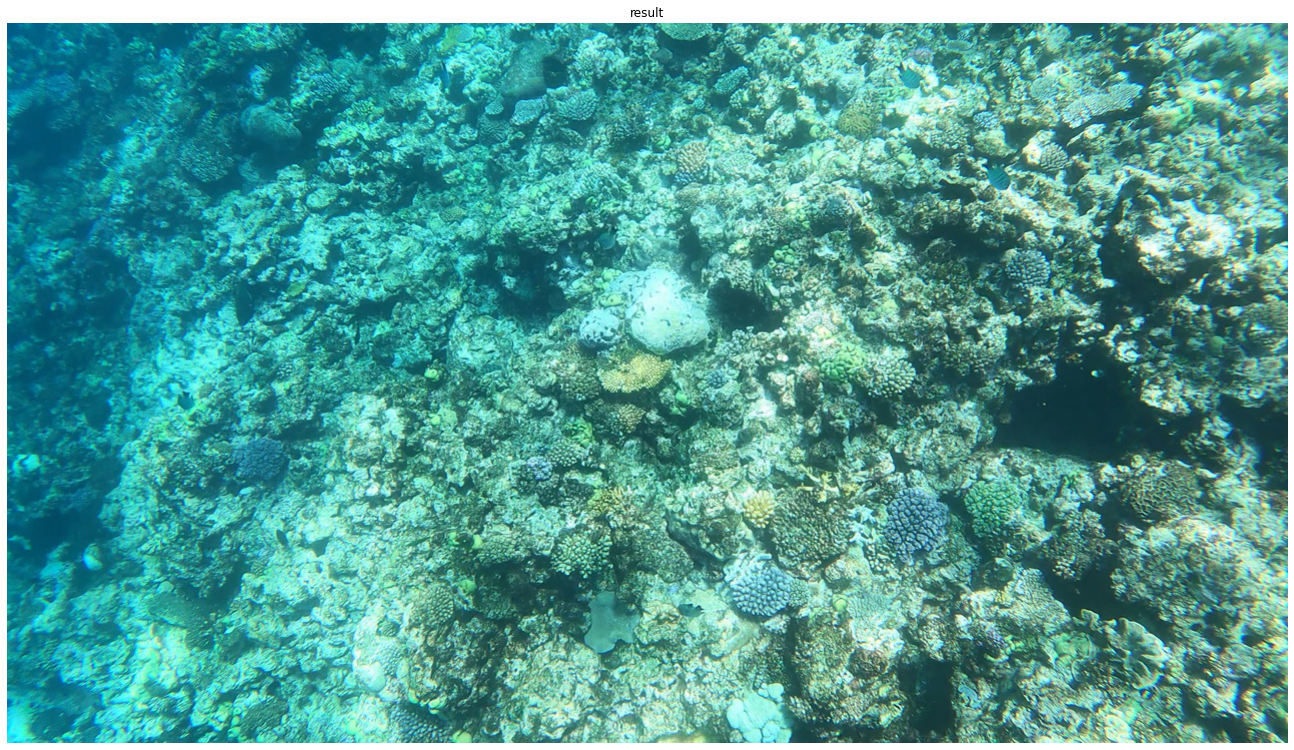

In [48]:
#result = inference_detector(model, img2)
#show_result_pyplot(model, img2[...,::-1], result)  

In [49]:
clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(14, 14))
for idx in tqdm(range(len(df_oof))):
    row = df_oof.loc[idx]
    img_path = row["image_path"]
    img = cv2.imread(str(img_path))
    for model_version, model in models.items():
        USE_CLACHE = meta_params[model_version].get("use_clahe", True)
        img2 = img.copy()
        if USE_CLACHE:
            for i in range(3):
                img2[:, :, i] = clahe.apply((img2[:, :, i]))     
        if meta_params[model_version]["tools"] == "yolov5":
            pred_bbox, confs = util.predict(model, img2, size=SIZE, augment=AUGMENT, use_sahi=USE_SAHI)
        elif meta_params[model_version]["tools"] == "mmdetection":
            result = inference_detector(model, img2)
            pred_bbox = result[0][:,:4]
            pred_bbox[:,2:] = pred_bbox[:,2:] - pred_bbox[:,:2]
            pred_confs = result[0][:,4]
            confs = pred_confs.tolist()
            
        df_oof.at[idx, "pred_bbox_" + model_version] = pred_bbox.tolist()
        df_oof.at[idx, "pred_confs_" + model_version] = confs

  0%|          | 0/3568 [00:00<?, ?it/s]

In [50]:
from ensemble_boxes import weighted_boxes_fusion

In [51]:
def run_wbf(bboxes, confs, image_size=1280, iou_thr=0.4, skip_box_thr=0.7, weights=None, conf_type='avg'):
    if len(bboxes) == 1:
        return bboxes[0], confs[0], []    
    boxes =  [bbox / (image_size-1) for bbox in bboxes]
    scores = [conf for conf in confs]    
    labels = [np.ones(len(conf)) for conf in confs]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr,conf_type=conf_type)
    boxes = boxes * (image_size-1)
    return boxes, scores, labels

In [52]:
# thr_s = []
# for iou_thr in range(1, 8):
#     iou_thr /= 10
#     for skip_box_thr in range(1,8):
#         skip_box_thr /= 10
#         gt_bboxs_list = []
#         prd_bboxs_list = []
#         df_oof_pos = df_oof.query("num_bbox > 0")
#         for idx in tqdm(range(len(df_oof))):
#             row = df_oof.iloc[idx]
#             gt_bboxs = row["real_bbox"]
#             gt_bboxs_list.append(np.array(gt_bboxs))
#             prd_bboxs_all = []
#             confis_all = []
#             for model_version in models.keys():
#                 bboxes, confis = row["pred_bbox_" + model_version], row["pred_confs_" + model_version]
#                 bboxes = np.array(bboxes)
#                 confis = np.array(confis)
#                 if len(confis) > 0:
#                     # xywh to xyxy
#                     bboxes[:,2:] = bboxes[:,:2] + bboxes[:,2:]
#                     prd_bboxs_all.append(bboxes)
#                     confis_all.append(confis)
#             if len(prd_bboxs_all) > 0:
#                 bboxes, confis, labels = run_wbf(prd_bboxs_all, confis_all, conf_type="avg", iou_thr=iou_thr, skip_box_thr=skip_box_thr)
#                 # xyxy to xywh
#                 if len(bboxes) > 0:
#                     wh = bboxes[:,2:] - bboxes[:,:2]
#                     bboxes[:,2:] = wh
#                 bboxes = bboxes.tolist()
#                 confis = confis.tolist()
#             else:
#                 bboxes, confis = [], []    
#             df_oof.at[idx, "pred_bbox"] = bboxes
#             df_oof.at[idx, "pred_confs"] = confis
#             prd_bboxs = [[confis[i]] + bboxes[i] for i in range(len(confis))]
#             prd_bboxs_list.append(np.array(prd_bboxs))

#         iou_ths = np.arange(0.3, 0.85, 0.05)
#         score = np.mean([calculate_score(prd_bboxs_list, gt_bboxs_list, iou_th) for iou_th in iou_ths])
#         tps, fps, fns = util.calc_f2_score(gt_bboxs_list, prd_bboxs_list, verbose=False)
#         df_oof["tp"], df_oof["fp"], df_oof["fn"] = tps, fps, fns    
#         score_2 = util.f_beta(*df_oof[["tp", "fp", "fn"]].sum(axis=0), beta=2) 
#         score_only_bbox =  util.f_beta(*df_oof.query("has_annotations")[["tp", "fp", "fn"]].sum(axis=0), beta=2) 
#         thr_s.append([iou_thr, skip_box_thr, score])
#         print(f"iou_thr {iou_thr}, skip_box_thr {skip_box_thr}: f2 method 1 {score:.4f},  method 2 {score_2:.4f}, score only consider those with bbox: {score_only_bbox:.4f}")

In [53]:
gt_bboxs_list = []
prd_bboxs_list = []
df_oof_pos = df_oof.query("num_bbox > 0")
for idx in tqdm(range(len(df_oof))):
    row = df_oof.iloc[idx]
    gt_bboxs = row["real_bbox"]
    gt_bboxs_list.append(np.array(gt_bboxs))
    prd_bboxs_all = []
    confis_all = []
    for model_version in models.keys():
        bboxes, confis = row["pred_bbox_" + model_version], row["pred_confs_" + model_version]
        bboxes = np.array(bboxes)
        confis = np.array(confis)
        if len(confis) > 0:
            # xywh to xyxy
            bboxes[:,2:] = bboxes[:,:2] + bboxes[:,2:]
            prd_bboxs_all.append(bboxes)
            confis_all.append(confis)
    if len(prd_bboxs_all) > 0:
        bboxes, confis, labels = run_wbf(prd_bboxs_all, confis_all, conf_type="avg", iou_thr=0.4, skip_box_thr=0.2)
        # xyxy to xywh
        if len(bboxes) > 0:
            wh = bboxes[:,2:] - bboxes[:,:2]
            bboxes[:,2:] = wh
        bboxes = bboxes.tolist()
        confis = confis.tolist()
    else:
        bboxes, confis = [], []    
    df_oof.at[idx, "pred_bbox"] = bboxes
    df_oof.at[idx, "pred_confs"] = confis
    prd_bboxs = [[confis[i]] + bboxes[i] for i in range(len(confis))]
    prd_bboxs_list.append(np.array(prd_bboxs))

  0%|          | 0/3568 [00:00<?, ?it/s]

In [54]:
from torchvision.ops import box_iou
def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 2:] = x[:, :2] + x[:, 2:]
    return y

def calculate_score(preds, gts,iou_th):
    num_tp = 0
    num_fp = 0
    num_fn = 0
    for p, gt in zip(preds, gts):
        if len(p) and len(gt):
            confs = p[:,0].argsort()
            iou_matrix = box_iou(torch.from_numpy(xywh2xyxy(p[:,1:])).int(), torch.from_numpy(xywh2xyxy(gt)).int())
            for i, idx in enumerate(confs):
                if iou_matrix.shape[1] == 0:
                    num_fp += len(confs) - i
                    break
                if iou_matrix[idx, :].max(0)[0] >= iou_th:
                    num_tp += 1
                    idxx = iou_matrix[idx, :].argmax()
                    iou_matrix = torch.cat((iou_matrix[:,:idxx], iou_matrix[:,idxx+1:]),dim=1)
                else:
                    num_fp += 1
            num_fn += iou_matrix.shape[1]
        elif len(p) == 0 and len(gt):
            num_fn += len(gt)
        elif len(p) and len(gt) == 0:
            num_fp += len(p)
            
    score = 5 * num_tp / (5 * num_tp + 4 * num_fn + num_fp)
    return score

In [55]:
target_score

{}

In [78]:
#conf_ths = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
conf_ths = [20]
iou_ths = np.arange(0.3, 0.85, 0.05)
model_names = list(models.keys())# + ["wbf"]
for conf_th in conf_ths:
    conf_th /= 100
    for model_version in model_names:
        if model_version == "wbf":
            pred_col = "pred_bbox"
            conf_col = "pred_confs"
        else:
            pred_col = "pred_bbox" + "_" + model_version
            conf_col = "pred_confs" + "_" + model_version
        prd_bboxs_list = []
        for index in df_oof.index:
            confis = df_oof.loc[index, conf_col]
            bboxes = df_oof.loc[index, pred_col]
            prd_bboxs = [[confis[i]] + bboxes[i] for i in range(len(confis)) if confis[i] >= conf_th]
            prd_bboxs_list.append(np.array(prd_bboxs))
        tps, fps, fns = util.calc_f2_score(gt_bboxs_list, prd_bboxs_list, verbose=False)
        df_oof["tp"], df_oof["fp"], df_oof["fn"] = tps, fps, fns    
        precision = util.f_beta(*df_oof[["tp", "fp", "fn"]].sum(axis=0), beta=0)
        recall = util.f_beta(*df_oof[["tp", "fp", "fn"]].sum(axis=0), beta=100)    
        score = util.f_beta(*df_oof[["tp", "fp", "fn"]].sum(axis=0), beta=2) 
        score_only_bbox =  util.f_beta(*df_oof.query("has_annotations")[["tp", "fp", "fn"]].sum(axis=0), beta=2) 
        print(f"conf_th {conf_th:.2f}, {model_version}: f2 {score:.4f}, precision {precision:.2f}, recall {recall:.2f} score only consider those with bbox: {score_only_bbox:.4f}")

conf_th 0.20, 0120_swin: f2 0.5861, precision 0.57, recall 0.59 score only consider those with bbox: 0.6208


In [66]:
# imgs = []
# for path in tqdm(df.query("fold != 4")["image_path"].sample(1000)):
#     img = cv2.imread(str(img_path))[...,::-1]
#     imgs.append(img)
# img_all = np.stack(imgs,axis=0)
# img_rs = img_all.reshape(-1,3)
# img_rs.mean(axis=0), img_rs.std(axis=0)

- 0111_yolov5l_fold0_new_hyp_remove_1: f2 method 1 0.5512,  method 2 0.5513, score only consider those with bbox: 0.5912
- 0118_yolov5l_fold0_new_hyp_remove_1_Clahe: f2 method 1 0.5419,  method 2 0.5419, score only consider those with bbox: 0.5838
- 0118_yolov5l_fold0_new_hyp_remove_1_noClahe: f2 method 1 0.5613,  method 2 0.5613, score only consider those with bbox: 0.5971
- wbf: f2 method 1 0.5528,  method 2 0.5562, score only consider those with bbox: 0.6372
- 0119_fastrcnn_pretrain_f4: f2 0.1237, score only consider those with bbox: 0.1242
- conf_th 0.20, 0120_swin: f2 0.5861, precision 0.57, recall 0.59 score only consider those with bbox: 0.6208

1. augment=False, conf=0.15, iou=0.5: 0.421, 0.427
2. augment=True, conf=0.15, iou=0.5: 0.444, 0.454
3. augment=True, conf=0, iou=0.5: 0.002, 0.008
4. augment=True, conf=0.15, iou=0.7: 0.442, 0.452
5. augment=True, conf=0.1, iou=0.7: 0.448, 0.463
6. augment=True, conf=0.1, iou=0.6: 0.451, 0.466
7. augment=True, conf=0.1, iou=0.5: 0.451, 0.467
8. **augment=True, conf=0.05, iou=0.4, small**: 0.452, 0.480
9. **augment=True, conf=0.05, iou=0.4, large**: 0.435, 0.445
10. **augment=True, conf=0.05, iou=0.4, large**: CV:0.6134, 0.471, 0.593
11. **augment=True, conf=0.05, iou=0.4, small clahe**: CV:0.48309, 0.453, 0.524
12. **small, augment=True, conf=0.05, iou=0.4, new hyp**: CV:0.488, 0.512, 0.541
13. **small, augment=True, conf=0.05, iou=0.4, new hyp**: CV:0.567, 0.542, 0.587
14. 0110_yolov5l_fold0_new_hyp_remove_noaug: CV 0.527, 0.508, 0.563 LB:0.425
15. 0111_yolov5l_fold0_new_hyp_remove_1: CV 0.553, 0.551, 0.591, LB:0.487

In [67]:
color_pred = [(0,255,0)]    
color_real = [(255,0,0)]
def plot_img(df, idx):
    row = df.loc[idx]
    path = row["image_path"]
    img = cv2.imread(str(path))[...,::-1]
    real_bboxes, bboxes, confis = row["real_bbox"], row["pred_bbox"], row["pred_confs"]
    display(util.show_img(img, 
                          bboxes + real_bboxes, 
                          color_pred + color_real, 
                          bbox_format='coco', 
                          labels= [0]*len(bboxes) + [1] * len(real_bboxes))
    )

## Most FN

In [68]:
most_fn = df_oof.sort_values("fn", ascending=False).head()
most_fn

video_id  sequence  video_frame  sequence_frame image_id  \
1277         0      8399         4553             815   0-4553   
1275         0      8399         4551             813   0-4551   
1298         0      8399         4574             836   0-4574   
1282         0      8399         4558             820   0-4558   
1287         0      8399         4563             825   0-4563   

                                            annotations  \
1277  [{'x': 190, 'y': 48, 'width': 50, 'height': 43...   
1275  [{'x': 191, 'y': 41, 'width': 50, 'height': 43...   
1298  [{'x': 154, 'y': 97, 'width': 52, 'height': 46...   
1282  [{'x': 186, 'y': 67, 'width': 50, 'height': 43...   
1287  [{'x': 179, 'y': 81, 'width': 50, 'height': 43...   

                                         old_image_path  \
1277  /home/vincent/Kaggle/data/tensorflow-great-bar...   
1275  /home/vincent/Kaggle/data/tensorflow-great-bar...   
1298  /home/vincent/Kaggle/data/tensorflow-great-bar...   
1282  /home/vincent/Kaggle/data/tensorflow-great-bar...   
1287  /home/vincent/Kaggle/data/tensorflow-great-bar...   

                                             image_path  \
1277  /home/vincent/Kaggle/data/tensorflow-great-bar...   
1275  /home/vincent/Kaggle/data/tensorflow-great-bar...   
1298  /home/vincent/Kaggle/data/tensorflow-great-bar...   
1282  /home/vincent/Kaggle/data/tensorflow-great-bar...   
1287  /home/vincent/Kaggle/data/tensorflow-great-bar...   

                                             label_path  \
1277  /home/vincent/Kaggle/data/tensorflow-great-bar...   
1275  /home/vincent/Kaggle/data/tensorflow-great-bar...   
1298  /home/vincent/Kaggle/data/tensorflow-great-bar...   
1282  /home/vincent/Kaggle/data/tensorflow-great-bar...   
1287  /home/vincent/Kaggle/data/tensorflow-great-bar...   

                                              real_bbox  num_bbox  \
1277  [[190, 48, 50, 43], [138, 70, 46, 31], [459, 1...         3   
1275  [[191, 41, 50, 43], [138, 66, 47, 31], [456, 1...         3   
1298  [[154, 97, 52, 46], [79, 120, 67, 46], [469, 2...         4   
1282  [[186, 67, 50, 43], [124, 81, 56, 40], [462, 1...         4   
1287  [[179, 81, 50, 43], [115, 99, 56, 40], [465, 1...         4   

      has_annotations  fold  \
1277             True     4   
1275             True     4   
1298             True     4   
1282             True     4   
1287             True     4   

                                              pred_bbox  \
1277  [[769.7944946289062, 327.4018859863281, 33.864...   
1275  [[762.41357421875, 322.0647888183594, 32.63507...   
1298  [[88.32460021972656, 122.78479766845703, 55.18...   
1282  [[131.5038604736328, 84.24751281738281, 50.852...   
1287  [[121.67523193359375, 106.51402282714844, 51.4...   

                                             pred_confs  \
1277        [0.35333970189094543, 0.057684965431690216]   
1275                              [0.07531001418828964]   
1298  [0.9827079176902771, 0.9493659734725952, 0.082...   
1282  [0.9824568033218384, 0.9632521867752075, 0.159...   
1287           [0.9882508516311646, 0.7835079431533813]   

                                    pred_bbox_0120_swin  \
1277  [[769.7944946289062, 327.4018859863281, 33.864...   
1275  [[762.41357421875, 322.0647888183594, 32.63507...   
1298  [[88.32460021972656, 122.78479766845703, 55.18...   
1282  [[131.5038604736328, 84.24751281738281, 50.852...   
1287  [[121.67523193359375, 106.51402282714844, 51.4...   

                                   pred_confs_0120_swin  tp  fp  fn  
1277        [0.35333970189094543, 0.057684965431690216]   0  11  33  
1275                              [0.07531001418828964]   0   0  33  
1298  [0.9827079176902771, 0.9493659734725952, 0.082...  15   7  29  
1282  [0.9824568033218384, 0.9632521867752075, 0.159...  15   7  29  
1287           [0.9882508516311646, 0.7835079431533813]  17   5  27

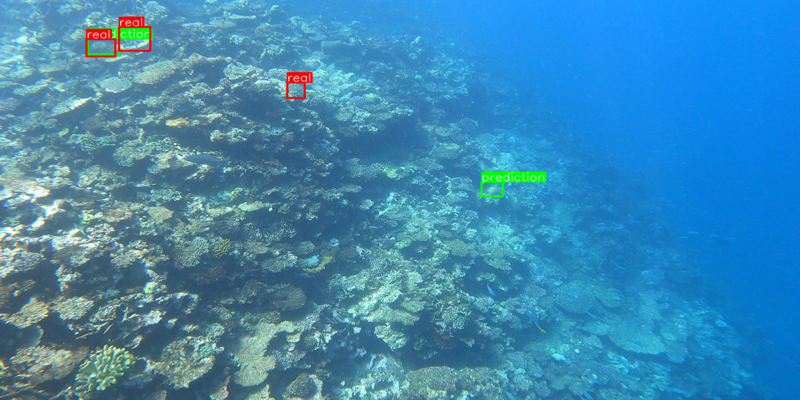

In [70]:
plot_img(df_oof, most_fn.index[0])

## Most FP

In [72]:
most_fp = df_oof.sort_values("fp", ascending=False).head()
most_fp

video_id  sequence  video_frame  sequence_frame image_id annotations  \
2833         1     15827         2127             209   1-2127          []   
2837         1     15827         2131             213   1-2131          []   
2492         1     44160         1249              10   1-1249          []   
1710         0      8399         4989            1251   0-4989          []   
1692         0      8399         4971            1233   0-4971          []   

                                         old_image_path  \
2833  /home/vincent/Kaggle/data/tensorflow-great-bar...   
2837  /home/vincent/Kaggle/data/tensorflow-great-bar...   
2492  /home/vincent/Kaggle/data/tensorflow-great-bar...   
1710  /home/vincent/Kaggle/data/tensorflow-great-bar...   
1692  /home/vincent/Kaggle/data/tensorflow-great-bar...   

                                             image_path  \
2833  /home/vincent/Kaggle/data/tensorflow-great-bar...   
2837  /home/vincent/Kaggle/data/tensorflow-great-bar...   
2492  /home/vincent/Kaggle/data/tensorflow-great-bar...   
1710  /home/vincent/Kaggle/data/tensorflow-great-bar...   
1692  /home/vincent/Kaggle/data/tensorflow-great-bar...   

                                             label_path real_bbox  num_bbox  \
2833  /home/vincent/Kaggle/data/tensorflow-great-bar...        []         0   
2837  /home/vincent/Kaggle/data/tensorflow-great-bar...        []         0   
2492  /home/vincent/Kaggle/data/tensorflow-great-bar...        []         0   
1710  /home/vincent/Kaggle/data/tensorflow-great-bar...        []         0   
1692  /home/vincent/Kaggle/data/tensorflow-great-bar...        []         0   

      has_annotations  fold  \
2833            False     4   
2837            False     4   
2492            False     4   
1710            False     4   
1692            False     4   

                                              pred_bbox  \
2833  [[857.0315551757812, 269.7256164550781, 21.907...   
2837  [[830.0944213867188, 119.45572662353516, 24.12...   
2492  [[827.0425415039062, 602.2012939453125, 44.892...   
1710  [[555.939697265625, 0.0, 37.391845703125, 16.7...   
1692  [[774.0816650390625, 304.86199951171875, 37.72...   

                                             pred_confs  \
2833  [0.44267669320106506, 0.2863236367702484, 0.23...   
2837  [0.5295272469520569, 0.21587730944156647, 0.20...   
2492  [0.8431845903396606, 0.42952680587768555, 0.22...   
1710  [0.8039490580558777, 0.24277451634407043, 0.20...   
1692  [0.9030795097351074, 0.390254408121109, 0.2033...   

                                    pred_bbox_0120_swin  \
2833  [[857.0315551757812, 269.7256164550781, 21.907...   
2837  [[830.0944213867188, 119.45572662353516, 24.12...   
2492  [[827.0425415039062, 602.2012939453125, 44.892...   
1710  [[555.939697265625, 0.0, 37.391845703125, 16.7...   
1692  [[774.0816650390625, 304.86199951171875, 37.72...   

                                   pred_confs_0120_swin  tp  fp  fn  
2833  [0.44267669320106506, 0.2863236367702484, 0.23...   0  33   0  
2837  [0.5295272469520569, 0.21587730944156647, 0.20...   0  33   0  
2492  [0.8431845903396606, 0.42952680587768555, 0.22...   0  33   0  
1710  [0.8039490580558777, 0.24277451634407043, 0.20...   0  33   0  
1692  [0.9030795097351074, 0.390254408121109, 0.2033...   0  33   0

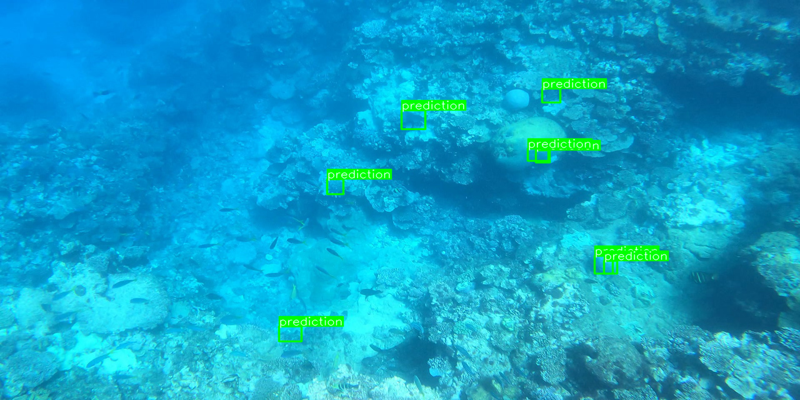

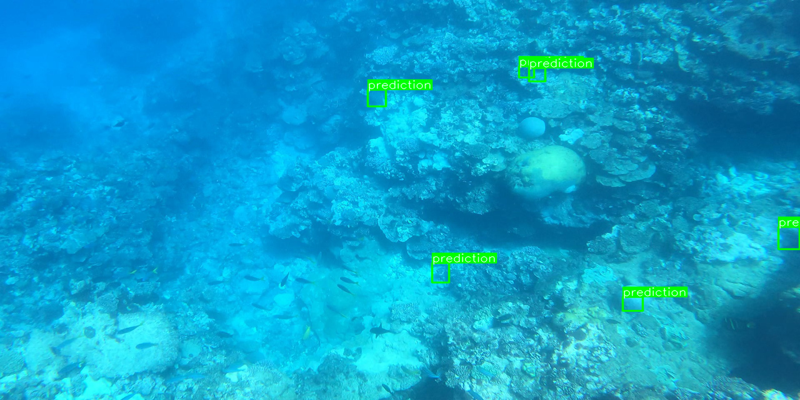

In [73]:
plot_img(df_oof, most_fp.index[0])
plot_img(df_oof, most_fp.index[1])

## Most TP

In [74]:
most_tp = df_oof.sort_values("tp", ascending=False).head()

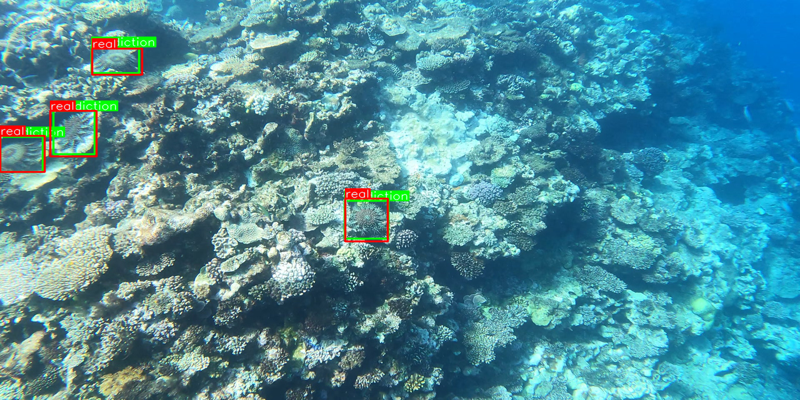

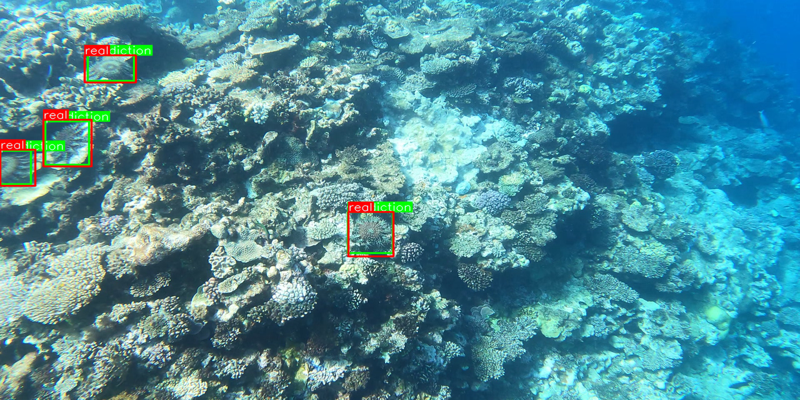

In [75]:
plot_img(df_oof, most_tp.index[0])
plot_img(df_oof, most_tp.index[1])

In [79]:
1

1